In [ ]:
%pip install deap

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

df = pd.read_csv('./data/processed_mrna_zscore.csv')

In [3]:
X = df.iloc[:, :-2]
y = df.iloc[:, -1]

Select 500 features by filtering methods.

In [4]:
file_path = './top_features_rf_500.txt'

with open(file_path, 'r') as file:
    content = file.read().splitlines()
top500 = content

The search space is now in 500 top features selected by a filtering methods

In [5]:
target_n = 50

In [6]:
import random
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.model_selection import StratifiedKFold
# Assuming X and y are your feature matrix and target variable
# X is a pandas DataFrame with 1800 samples and 500 features
# y is a pandas Series with the corresponding labels

# DEAP initialization
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Function to create an individual (binary representation of features)
def create_individual():
    return np.random.choice(top500, size=target_n, replace=False)

def mutate(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            remain = [feat for feat in top500 if feat not in individual]
            individual[i] = np.random.choice(remain)

    return individual,
# DEAP Toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

Genetic algorithm settings

In [7]:
population_size = 50
generations = 20
crossover_rate = 0.8
mutation_rate = 0.1

In [8]:
def execuate_ga(clf):
    # Collect fitness values for plotting
    mean_fitness_values = []

    population = toolbox.population(n=population_size)

    for gen in range(generations):
        # Evaluate the entire population
        fitness_values = list(toolbox.map(toolbox.evaluate, population))
        
        # Update the fitness values
        for ind, fit in zip(population, fitness_values):
            ind.fitness.values = fit
        
        # Select the next generation individuals
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
        
        # Evaluate offspring
        fitness_values = list(toolbox.map(toolbox.evaluate, offspring))
        for ind, fit in zip(offspring, fitness_values):
            ind.fitness.values = fit
        
        # Select the next generation from offspring
        population = toolbox.select(offspring + population, k=population_size)
        
        # Collect the highest fitness value for this generation
        mean_fitness = np.array([ind.fitness.values[0] for ind in population]).mean()
        mean_fitness_values.append(mean_fitness)

        # Print the highest fitness value for this generation
        print(f"Generation {gen + 1}: Mean Fitness = {mean_fitness}")

    
    # Plotting
    plt.plot(range(1, generations + 1), mean_fitness_values, marker='o')
    plt.xlabel('Generation')
    plt.ylabel('Mean Fitness Value')
    plt.title('Evolution of Highest Fitness Value')
    plt.show()

    # Get the best individual from the final population
    best_individual = tools.selBest(population, k=1)[0]


    np.savetxt(f'top_features_gen_{clf}.txt', best_individual, fmt='%s')

    print("Best individual:", best_individual)

    return mean_fitness_values

Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Function to evaluate the fitness of an individual
def evaluate_individual_rf(individual):
    selected_features = individual
    # print('selected_features: ', selected_features)
    
    if not selected_features:
        return 0.0,  # Avoid all-zero individuals
    
    clf = RandomForestClassifier(random_state=42, n_estimators=10, n_jobs=-1)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    sel_X = X[selected_features]
    for train_index, test_index in skf.split(sel_X, y):
        X_train, X_test = sel_X.iloc[train_index], sel_X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Apply SMOTE on the training set
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        clf.fit(X_resampled, y_resampled)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    return average_accuracy,

toolbox.register("evaluate", evaluate_individual_rf)

Generation 1: Mean Fitness = 0.8064848484848484
Generation 2: Mean Fitness = 0.808070707070707
Generation 3: Mean Fitness = 0.8102727272727271
Generation 4: Mean Fitness = 0.8123737373737373
Generation 5: Mean Fitness = 0.8135050505050504
Generation 6: Mean Fitness = 0.8147070707070705
Generation 7: Mean Fitness = 0.8156060606060607
Generation 8: Mean Fitness = 0.8166868686868685
Generation 9: Mean Fitness = 0.8171414141414141
Generation 10: Mean Fitness = 0.8171717171717171
Generation 11: Mean Fitness = 0.8171717171717171
Generation 12: Mean Fitness = 0.8171717171717171
Generation 13: Mean Fitness = 0.8171717171717171
Generation 14: Mean Fitness = 0.8171717171717171
Generation 15: Mean Fitness = 0.8171717171717171
Generation 16: Mean Fitness = 0.8172929292929291
Generation 17: Mean Fitness = 0.8175959595959594
Generation 18: Mean Fitness = 0.818111111111111
Generation 19: Mean Fitness = 0.8184747474747474
Generation 20: Mean Fitness = 0.8186565656565656


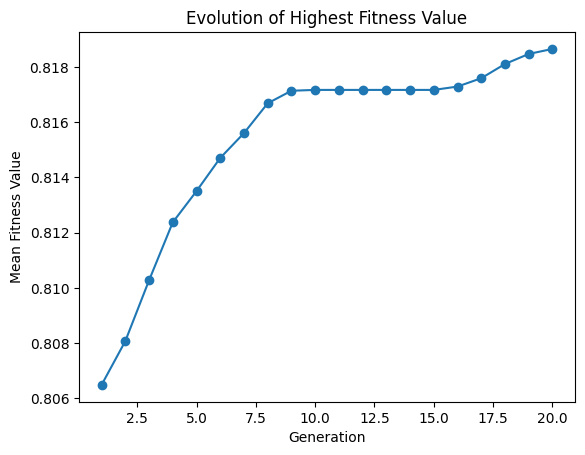

Best individual: ['RXFP3', 'VCPIP1', 'FRAT1', 'CLCN2', 'CRYBG2', 'DYM', 'WDR19', 'CYP4F3', 'SLC41A3', 'SPACA7', 'STIL', 'GOLGA6L1', 'C17orf50', 'C10orf129', 'NFIB', 'SUSD3', 'SMIM5', 'IDUA', 'GRHPR', 'DYDC1', 'RUNDC1', 'FUT10', 'LINC01704', 'TMEM144', 'HGC6.3', 'CSPG4P5', 'BPIFA1', 'SLC30A2', 'HAGHL', 'C21orf136', 'CPNE2', 'SNRPD2', 'CCDC170', 'GRHL1', 'HGC6.1.1', 'AK8', 'SHB', 'PCDHA1', 'POLR1E', 'TMA16', 'PAK1IP1', 'C5orf34', 'PNMA6A', 'LOC100130051', 'PRKG2', 'FGFR4', 'ABHD14A', 'LINC00346', 'LONRF2', 'TINCR']


[0.8064848484848484,
 0.808070707070707,
 0.8102727272727271,
 0.8123737373737373,
 0.8135050505050504,
 0.8147070707070705,
 0.8156060606060607,
 0.8166868686868685,
 0.8171414141414141,
 0.8171717171717171,
 0.8171717171717171,
 0.8171717171717171,
 0.8171717171717171,
 0.8171717171717171,
 0.8171717171717171,
 0.8172929292929291,
 0.8175959595959594,
 0.818111111111111,
 0.8184747474747474,
 0.8186565656565656]

In [13]:
execuate_ga('rf')

In [10]:
best = ['CASP10', 'TMEM98', 'DBP', 'FAM21C', 'FAM177B', 'SLC35C1', 'CBWD1', 'SLC30A2', 'PCBD2', 'OR6B2', 'TRIM9', 'C17orf50', 'LINC01838', 'AVP', 'LPHN1', 'HOXA4', 'SELENOT', 'GRHPR', 'IDH3GL', 'CSPG4P5', 'MEMO1', 'EPO', 'OLFM4', 'AUNIP', 'TMEM99', 'LONRF2', 'GTF2E2', 'RDH10', 'RXFP3', 'GMPS', 'RORB', 'GREB1', 'SNRPA1', 'EGLN3', 'HCAR2', 'NOP16', 'CENPL', 'OR8J1', 'C1QTNF9B', 'CPEB2', 'ARSK', 'FGG', 'CPNE2', 'FAM111A', 'MOBP', 'VCP', 'ERBB2', 'HGC6.1.1', 'HP1BP3', 'NRDC']

In [12]:
np.unique(best).shape

(50,)

In [ ]:
mean_fitness_values = [0.8064848484848484,
 0.808070707070707,
 0.8102727272727271,
 0.8123737373737373,
 0.8135050505050504,
 0.8147070707070705,
 0.8156060606060607,
 0.8166868686868685,
 0.8171414141414141,
 0.8171717171717171,
 0.8171717171717171,
 0.8171717171717171,
 0.8171717171717171,
 0.8171717171717171,
 0.8171717171717171,
 0.8172929292929291,
 0.8175959595959594,
 0.818111111111111,
 0.8184747474747474,
 0.8186565656565656]

plt.plot(range(1, generations + 1), mean_fitness_values, marker='o', color='orange')
plt.xlabel('Generation')
plt.ylabel('Mean Fitness Value')
plt.title('Mean Fitness Value - GA and Random Forest')
plt.show()

SVM

In [ ]:
from sklearn.svm import SVC

# Function to evaluate the fitness of an individual
def evaluate_individual_svm(individual):
    selected_features = individual
    # print('selected_features: ', selected_features)
    
    if not selected_features:
        return 0.0,  # Avoid all-zero individuals
    
    clf = SVC(random_state=42)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    sel_X = X[selected_features]
    for train_index, test_index in skf.split(sel_X, y):
        X_train, X_test = sel_X.iloc[train_index], sel_X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    return average_accuracy,

In [ ]:
toolbox.register("evaluate", evaluate_individual_svm)
execuate_ga('svm')

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Function to evaluate the fitness of an individual
def evaluate_individual_dt(individual):
    selected_features = individual
    # print('selected_features: ', selected_features)
    
    if not selected_features:
        return 0.0,  # Avoid all-zero individuals
    
    clf = DecisionTreeClassifier(random_state=42)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    sel_X = X[selected_features]
    for train_index, test_index in skf.split(sel_X, y):
        X_train, X_test = sel_X.iloc[train_index], sel_X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    return average_accuracy,

In [ ]:
toolbox.register("evaluate", evaluate_individual_dt)
execuate_ga('dt')

XGB Boost

In [ ]:
import xgboost as xgb
# Function to evaluate the fitness of an individual
def evaluate_individual_xgb(individual):
    selected_features = individual
    # print('selected_features: ', selected_features)
    
    if not selected_features:
        return 0.0,  # Avoid all-zero individuals
    
    clf = xgb.XGBClassifier(random_state=42, n_estimators=10, n_jobs=-1)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    sel_X = X[selected_features]
    for train_index, test_index in skf.split(sel_X, y):
        X_train, X_test = sel_X.iloc[train_index], sel_X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    return average_accuracy,

In [ ]:
toolbox.register("evaluate", evaluate_individual_xgb)
execuate_ga('xgb')

Neural network

In [ ]:
from sklearn.neural_network import MLPClassifier
neuralNetwork = MLPClassifier(hidden_layer_sizes=(10, ), random_state=42, max_iter=100)

# Function to evaluate the fitness of an individual
def evaluate_individual_nn(individual):
    selected_features = individual
    # print('selected_features: ', selected_features)
    
    if not selected_features:
        return 0.0,  # Avoid all-zero individuals
    
    clf = neuralNetwork
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    sel_X = X[selected_features]
    for train_index, test_index in skf.split(sel_X, y):
        X_train, X_test = sel_X.iloc[train_index], sel_X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    return average_accuracy,

In [ ]:
toolbox.register("evaluate", evaluate_individual_nn)
execuate_ga('nn')